# Random Effects Neural Networks with Edward and Keras
Bayesian probabilistic models provide a nimble and expressive framework for modeling "small-world" data plus a host of tools for vigorously criticizing the models we build. In contrast, deep learning offers a more rigid yet much more powerful framework for modeling data of massive size. Edward is a probabilistic programming library that bridges this gap: "black-box" variational inference allows us to fit extremely flexible Bayesian models to large-scale data. Furthermore, these models themselves may take advantage of classic deep-learning architectures.

Edward uses [TensorFlow](https://www.tensorflow.org/) for symbolic gradients and data flow graphs. As such, it interfaces cleanly with other libraries that do the same, namely [TF-Slim](https://research.googleblog.com/2016/08/tf-slim-high-level-library-to-define.html), [PrettyTensor](https://github.com/google/prettytensor) and [Keras](https://keras.io/). Personally, I've been working often with the latter, and am consistently delighted by the ease with which it allows me to specify complex neural architectures.

The goal of this post is to lay a practical foundation for Bayesian modeling in Edward, then explore how, and how easily, we can extend these models in the direction of classical deep learning. It will give both a conceptual overview of the models below, as well as notes on the practical considerations of their implementation in Edward and Keras -- what worked and what didn't. Finally, this post will conclude with concrete ways in which to extend these models even further, of which there are many.

Below, we build three models in sequential fashion: a Bayesian linear regression model, a Bayesian linear regression model with random effects, and a neural network with random effects. We fit this model on the [Zillow Prize](https://www.kaggle.com/c/zillow-prize-1) dataset.

In [201]:
import edward as ed
from edward.models import Normal
from keras.layers import Input, Dense
from keras.regularizers import l2
from keras import backend as K
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import scale

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [202]:
sess = ed.get_session()
K.set_session(sess)

INIT_OP = tf.global_variables_initializer()

## Data preparation
After importing the data we rename its columns as per Philipp Spachtholz's [Exploratory Analysis - Zillow](https://www.kaggle.com/philippsp/exploratory-analysis-zillow) kernel on [kaggle.com](https://www.kaggle.com).

In [254]:
properties_df = pd.read_csv('data/properties.csv', low_memory=False)
transactions_df = pd.read_csv('data/transactions.csv')

In [255]:
properties_df = properties_df.rename(columns={
    'parcelid': 'id_parcel',
    'yearbuilt': 'build_year',
    'basementsqft': 'area_basement',
    'yardbuildingsqft17': 'area_patio',
    'yardbuildingsqft26': 'area_shed',
    'poolsizesum': 'area_pool',
    'lotsizesquarefeet': 'area_lot',
    'garagetotalsqft': 'area_garage',
    'finishedfloor1squarefeet': 'area_firstfloor_finished',
    'calculatedfinishedsquarefeet': 'area_total_calc',
    'finishedsquarefeet6': 'area_base',
    'finishedsquarefeet12': 'area_live_finished',
    'finishedsquarefeet13': 'area_liveperi_finished',
    'finishedsquarefeet15': 'area_total_finished',
    'finishedsquarefeet50': 'area_unknown',
    'unitcnt': 'num_unit',
    'numberofstories': 'num_story',
    'roomcnt': 'num_room',
    'bathroomcnt': 'num_bathroom',
    'bedroomcnt': 'num_bedroom',
    'calculatedbathnbr': 'num_bathroom_calc',
    'fullbathcnt': 'num_bath',
    'threequarterbathnbr': 'num_75_bath',
    'fireplacecnt': 'num_fireplace',
    'poolcnt': 'num_pool',
    'garagecarcnt': 'num_garage',
    'regionidcounty': 'region_county',
    'regionidcity': 'region_city',
    'regionidzip': 'region_zip',
    'regionidneighborhood': 'region_neighbor',
    'taxvaluedollarcnt': 'tax_total',
    'structuretaxvaluedollarcnt': 'tax_building',
    'landtaxvaluedollarcnt': 'tax_land',
    'taxamount': 'tax_property',
    'assessmentyear': 'tax_year',
    'taxdelinquencyflag': 'tax_delinquency',
    'taxdelinquencyyear': 'tax_delinquency_year',
    'propertyzoningdesc': 'zoning_property',
    'propertylandusetypeid': 'zoning_landuse',
    'propertycountylandusecode': 'zoning_landuse_county',
    'fireplaceflag': 'flag_fireplace',
    'hashottuborspa': 'flag_tub',
    'buildingqualitytypeid': 'quality',
    'buildingclasstypeid': 'framing',
    'typeconstructiontypeid': 'material',
    'decktypeid': 'deck',
    'storytypeid': 'story',
    'heatingorsystemtypeid': 'heating',
    'airconditioningtypeid': 'aircon',
    'architecturalstyletypeid': 'architectural_style'
})

transactions_df = transactions_df.rename(columns={
  'parcelid': 'id_parcel',
  'transactiondate': 'date'
})

### Build training DataFrame

In [256]:
data = transactions_df.merge(properties_df, how='left', left_on='id_parcel', right_on='id_parcel')

### Drop columns containing too many nulls

In [257]:
keep_cols = data.columns[ data.isnull().mean() < .25 ]
data = data[keep_cols]

### Which columns are most correlated with the target?

In [258]:
float_cols = [col for col in data.columns if data[col].dtype == np.float64]

data[float_cols]\
    .corr()['logerror']\
    .abs()\
    .sort_values(ascending=False)\
    .head(10)

logerror               1.000000
area_live_finished     0.041922
area_total_calc        0.038784
num_bathroom_calc      0.029448
num_bath               0.028845
num_bathroom           0.027889
num_bedroom            0.025467
tax_building           0.022085
build_year             0.017312
censustractandblock    0.008892
Name: logerror, dtype: float64

### Drop rows with null values
- make mention of the fact that you want to impute missing values

In [208]:
data.dropna(inplace=True)
data.reset_index(inplace=True)

### Select three fixed-effect predictors

In [209]:
fixed_effect_predictors = [
    'area_live_finished', 
    'num_bathroom', 
    'build_year'
]

### Select one random-effect predictor

In [210]:
zip_codes = data['region_zip'].astype('category').cat.codes

### Split data into train, validation sets

In [242]:
train_index = data.sample(frac=0.5).index
val_index = data.drop(train_index).index

X = data.drop('logerror', axis=1)[fixed_effect_predictors]
X = scale(X)
y = data['logerror'].values

X_train = X[train_index]
y_train = y[train_index]
X_val = X[val_index]
y_val = y[val_index]

print('Dataset sizes:')
print(f'    X_train:  {X_train.shape}')
print(f'    X_val:    {X_val.shape}')
print(f'    y_train:  {y_train.shape}')
print(f'    y_val:    {y_val.shape}')

Dataset sizes:
    X_train:  (36986, 3)
    X_val:    (36986, 3)
    y_train:  (36986,)
    y_val:    (36986,)


# Bayesian linear regression

### Fit model

In [244]:
N, D = X_train.shape

# fixed-effects placeholders
fixed_effects = tf.placeholder(tf.float32, [N, D])

# fixed-effects parameters
β_fixed_effects = Normal(loc=tf.zeros(D), scale=tf.ones(D))
α = Normal(loc=tf.zeros(1), scale=tf.ones(1))

# model
μ_y = α + ed.dot(fixed_effects, β_fixed_effects)
y = Normal(loc=μ_y, scale=tf.ones(N))

# approximate fixed-effects distributions 
qβ_fixed_effects = Normal(
    loc=tf.Variable(tf.random_normal([D])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([D])))
)
qα = Normal(
    loc=tf.Variable(tf.random_normal([1])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([1])))
)

In [245]:
latent_vars = {
    β_fixed_effects: qβ_fixed_effects,
    α: qα
}

sess.run(INIT_OP)
inference = ed.KLqp(latent_vars, data={fixed_effects: X_train, y: y_train})
inference.run(n_samples=5, n_iter=250)

250/250 [100%] ██████████████████████████████ Elapsed: 18s | Loss: 35045.938


In [246]:
# something about what the softplus is, why we do the following, etc.
# something about variable shapes

### Criticize model

In [234]:
def visualize_data_fit(X, y, β, α, title_prefix, n_samples=10):
    '''Plot lines generated via samples from parameter distributions of the first 
    two fixed effects, vs. observed data points.
    Args:
        X (np.array) : A design matrix of fixed effects.
        y (np.array) : A vector of responses.
        β (ed.RandomVariable) : A (presumably) multivariate distribution of fixed-effect parameters.
        α (ed.RandomVariable) : A univariate distribution of the model's intercept term.
        title_prefix (str) : A string to append to the beginning of the title.
        n_samples (int) : The number of lines to plot as drawn from the parameter distributions.
    '''
    
    # draw samples from parameter distributions
    β_samples = β.sample(n_samples).eval()
    α_samples = α.sample(n_samples).eval()
    
    # plot the first two dimensions of `X`, vs. `y`
    fig = plt.figure(figsize=(12, 9))
    ax = plt.axes(projection='3d')
    ax.scatter(X[:, 0], X[:, 1], y)
    plt.title(f'{title_prefix} Parameter Samples vs. Observed Data')
    
    # plot lines defined by parameter samples
    inputs = np.linspace(-10, 10, num=500)
    for i in range(n_samples):
        output = inputs * β_samples[i][0] + inputs * β_samples[i][1] + α_samples[i][0]
        ax.plot(inputs, inputs, output)

#### Visualize data fit given parameter priors

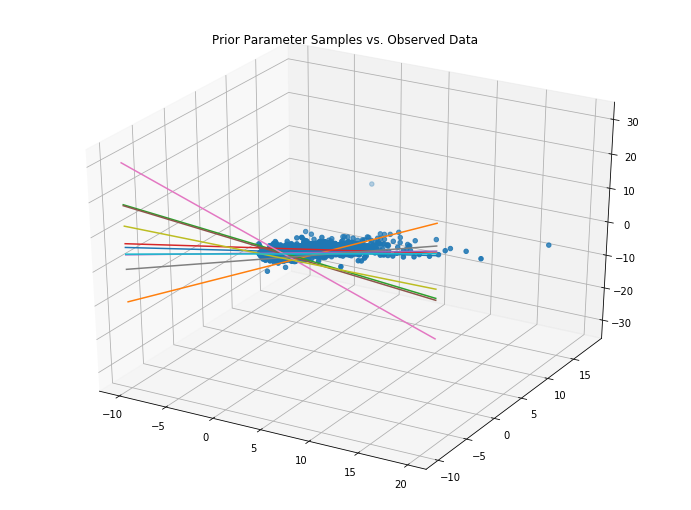

In [32]:
visualize_data_fit(X_train, y_train, β_fixed_effects, α, 'Prior', n_samples=10)

#### Visualize data fit given parameter posteriors

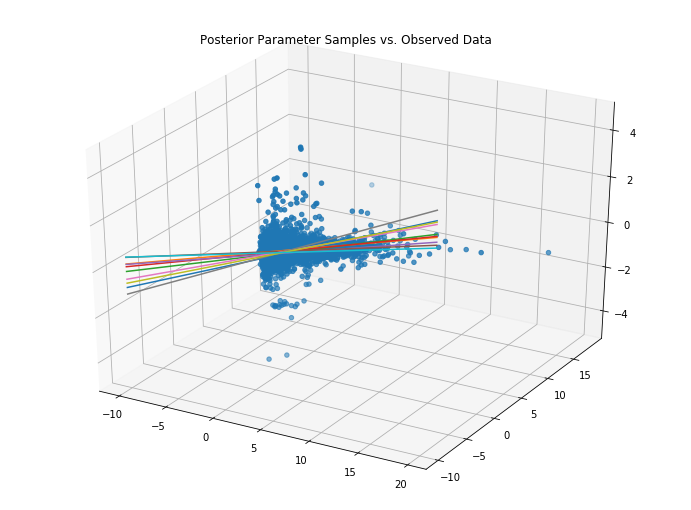

In [33]:
visualize_data_fit(X_train, y_train, qβ_fixed_effects, qα, 'Posterior', n_samples=10)

In [56]:
# note the axis scales as well!

# just because we fit the data doesn't mean we're fitting it well. this will become clearer when we compute the MAE.

#### Inspect residuals

In [176]:
def compute_mean_absolute_error(y_posterior, X_val_feed_dict, y_val=y_val):
    data = {y_posterior: y_val}
    data.update(X_val_feed_dict)
    mae = ed.evaluate('mean_absolute_error', data=data)
    print(f'Mean absolute error on validation data: {mae:1.5}')
    
def plot_residuals(y_posterior, X_val_feed_dict, title, y_val=y_val):
    y_posterior_preds = y_posterior.eval(feed_dict=X_val_feed_dict)
    plt.hist(y_posterior_preds - y_val, edgecolor='white', linewidth=1, bins=30, alpha=.7)
    plt.axvline(0, color='#A60628', linestyle='--')
    plt.xlabel('`y_posterior_preds - y_val`', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.title(title, fontsize=16)

In [247]:
# if we omit the `.mean()` we still get point estimates for our posterior predictive. how do we get the full distribution?
param_posteriors = {
    β_fixed_effects: qβ_fixed_effects.mean(),
    α: qα.mean()
}
X_val_feed_dict = {
    fixed_effects: X_val
}
y_posterior = ed.copy(y, param_posteriors)

In [248]:
compute_mean_absolute_error(y_posterior, X_val_feed_dict)

Mean absolute error on validation data: 0.086043


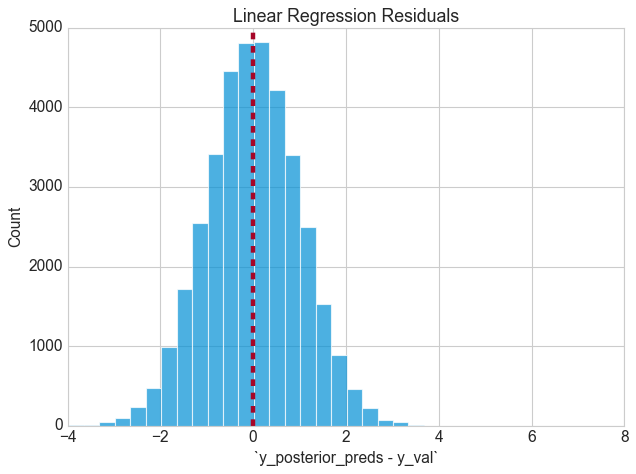

In [177]:
plot_residuals(y_posterior, X_val_feed_dict, title='Linear Regression Residuals')

#### Inspect parameter posteriors

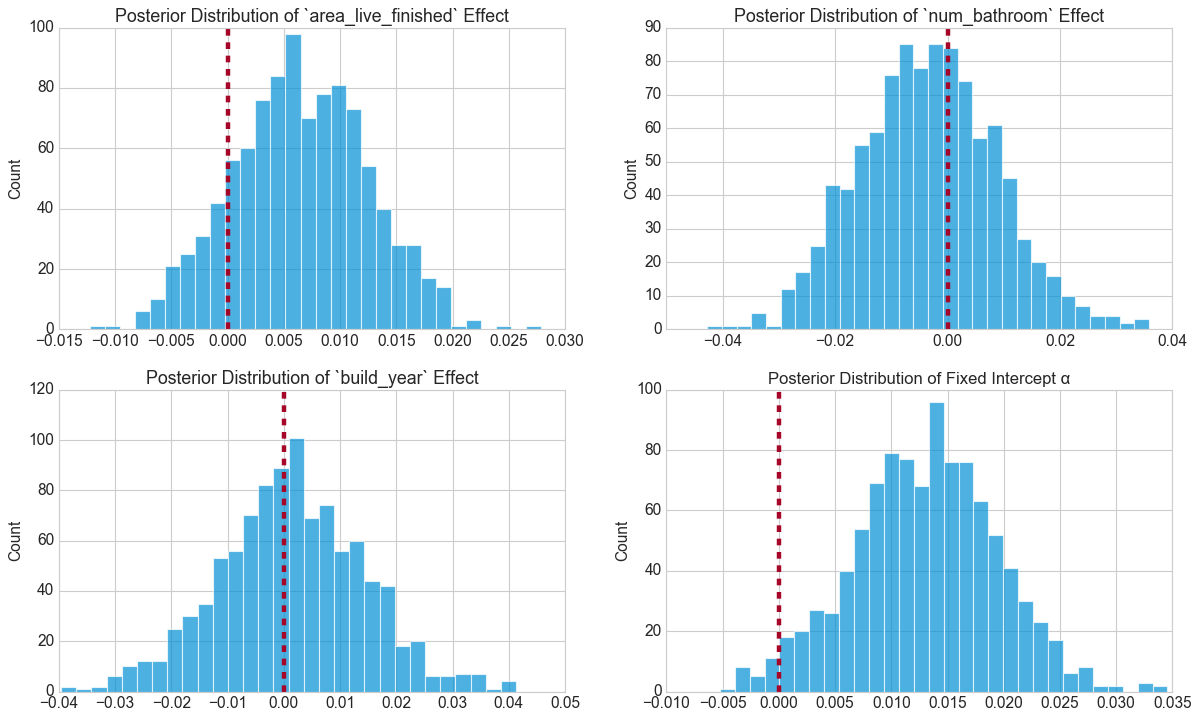

In [179]:
# draw samples from posteriors
qβ_fixed_effects_samples = qβ_fixed_effects.sample(1000).eval()
qα_samples = qα.sample(1000).eval()

# plot samples
plt.figure(figsize=(16, 10))

for dimension in range(D):
    subplot = plt.subplot(221 + dimension)
    plt.hist(qβ_fixed_effects_samples[:, dimension], edgecolor='white', linewidth=1, bins=30, alpha=.7)
    plt.axvline(0, color='#A60628', linestyle='--')
    title = f'Posterior Distribution of `{fixed_effect_predictors[dimension]}` Effect'
    plt.ylabel('Count', fontsize=14)
    plt.title(title, fontsize=16)
    
subplot = plt.subplot(221 + dimension + 1)
plt.hist(qα_samples, edgecolor='white', linewidth=1, bins=30, alpha=.7)
plt.axvline(0, color='#A60628', linestyle='--')
title = f'Posterior Distribution of Fixed Intercept α'
plt.ylabel('Count', fontsize=14)
plt.title(title, fontsize=15)

In [185]:
# "conditional on the assumptions that the log error and other variables can be related by a straight line..."
# "multivariate regression model allows us to the answer the question: “what the is the predictive value of one variable once I already know the values of all other variables?”"
# - once I know A, what additional value is there in knowing B?
# - once I know B, what additional value is there in knowing A?
# the addition can be interpreted as an “or:”  μ  is a function of  x1  or  x2 
# the “or” indicates independent associations, which may be statistical or rather causal

# conservative maximum entropy distributions do an excellent job in this context
# multilevel models also go by the following names:
# hierarchical
# mixed effects

# intercepts were “shrunk” towards the intercept-mean  α , as the two extra parameters ( α  and  σ ) and their hyperpriors allowed the model to learn a more aggressive regularizing prior in an adaptive context

# in the above multilevel tadpole model, we put a prior around the variance  σ  of the population survival proportion distribution
# this can be problematic for two reasons:
# if we only had 5 clusters (in our example, we had 48), that’s a bit like trying to estimate a variance with 5 data points
# in non-linear models with logit and log links, floor and ceiling effects sometimes render extreme values of the variance equally plausible as more realistic values

# in the partial pooling (multilevel) approach, we get results that walk the line between underfit and overfit
# small clusters are prone to overfit, so they receive a bigger dose of the underfit grand mean (complete pooling)
# large clusters “shrink” much less because they contain more information and are less prone to overfitting (and therefore need less correcting, i.e. “shrinking”), and therefore just don’t have very far to go (i.e. be pulled towards a global mean)
# while partial pooling has little effect on large clusters, the information learned from these clusters can help substantially with prediction in small clusters
# the whole point is to shrink estimates towards the mean
# regularization

# this “pulling/shrinking/learn things amongst the clusters” is a form of regularization, but now an amount of regularization that is learned from the data itself

#   - in this way, you can think of the sigma parameter for each cluster as a crude measure of the cluster's relevance for explaining variation in the outcome

## Bayesian linear regression with random effects

### Fit model

In [61]:
n_zip_codes = len(set(zip_codes))

# random-effect placeholder
zip_codes_ph = tf.placeholder(tf.int32, [None])

# random-effect parameter
σ_zip_code = tf.sqrt(tf.exp(tf.Variable(tf.random_normal([]))))
α_zip_code = Normal(loc=tf.zeros(n_zip_codes), scale=σ_zip_code * tf.ones(n_zip_codes))
    
# model
α_random_effects = tf.gather(α_zip_code, zip_codes_ph)
μ_y = α + α_random_effects + ed.dot(fixed_effects, β_fixed_effects)
y = Normal(loc=μ_y, scale=tf.ones(N))

# approximate random-effect distribution
qα_zip_code = Normal(
    loc=tf.Variable(tf.random_normal([n_zip_codes])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_zip_codes])))
)

In [70]:
latent_vars = {
    β_fixed_effects: qβ_fixed_effects,
    α: qα,
    α_zip_code: qα_zip_code
}

sess.run(INIT_OP)
inference = ed.KLqp(latent_vars, data={fixed_effects: X_train, zip_codes_ph: zip_codes[train_index], y: y_train})
inference.run(n_samples=5, n_iter=1000)

1000/1000 [100%] ██████████████████████████████ Elapsed: 14s | Loss: 34535.785


### Criticize model

In [71]:
param_posteriors = {
    β_fixed_effects: qβ_fixed_effects.mean(),
    α: qα.mean(),
    α_zip_code: qα_zip_code.mean()
}
X_val_feed_dict = {
    fixed_effects: X_val,
    zip_codes_ph: zip_codes[val_index]
}
y_posterior = ed.copy(y, param_posteriors)

In [74]:
compute_mean_absolute_error(y_posterior, X_val_feed_dict)

Mean absolute error on validation data: 0.080423


#### Inspect residuals

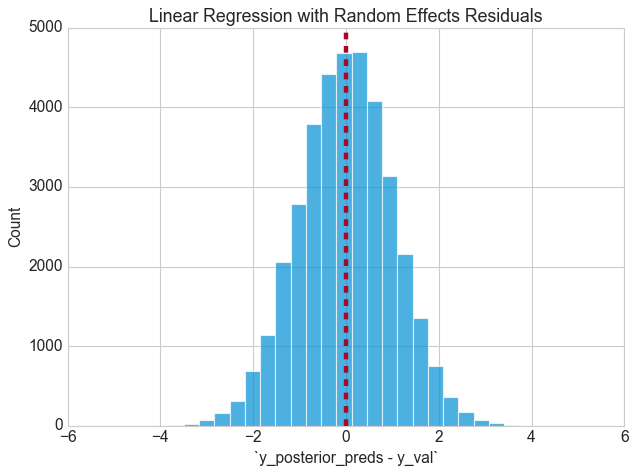

In [180]:
plot_residuals(y_posterior, X_val_feed_dict, title='Linear Regression with Random Effects Residuals')

#### Inspect shrinkage

In [253]:
latent_vars = {
    β_fixed_effects: qβ_fixed_effects,
    α: qα
}
qα_means = {}
for zip_code in zip_codes[train_index].unique():
    # compute mask, number of observations
    mask = zip_codes[train_index] == zip_code
    N_ = mask.sum()
    
    # instantiate model for current zip_code
    fixed_effects = tf.placeholder(tf.float32, [N_, D])
    μ_y = α + ed.dot(fixed_effects, β_fixed_effects)
    y = Normal(loc=μ_y, scale=tf.ones(N_))
    
    # fit model
    sess.run(INIT_OP)
    inference = ed.KLqp(latent_vars, data={fixed_effects: X_train[mask], y: y_train[mask]})
    inference.run(n_samples=5, n_iter=25)
    
    # log mean of qα for this zip code
    qα_means[zip_code] = qα.mean().eval()
    print(f'{zip_code}: {qα_means[zip_code]}')

366: [ 0.08759987]
32: [ 0.08720303]
192: [-0.12035958]
227: [ 0.00507673]
349: [-0.08735152]
143: [-0.13157961]
178: [-0.521294]
195: [-0.44123179]
242: [ 0.53971499]
53: [-1.5017997]
121: [-0.06459984]
270: [ 0.03163562]
309: [ 0.41763553]
186: [-0.1009969]
352: [ 0.43580648]
336: [ 0.10926886]
204: [ 0.25365964]
315: [ 0.24507535]
64: [ 0.84832913]
95: [ 0.04370175]
362: [ 0.08141328]
370: [-0.07470678]
262: [-0.0313549]
235: [-0.11599839]
268: [ 0.3570548]
85: [-0.07640077]
40: [ 0.21029568]
260: [-0.04384869]
107: [ 0.44413629]
311: [ 0.04160207]
272: [ 0.054246]
307: [-0.17320077]
210: [ 0.32317492]
327: [ 0.16865198]


KeyboardInterrupt: 

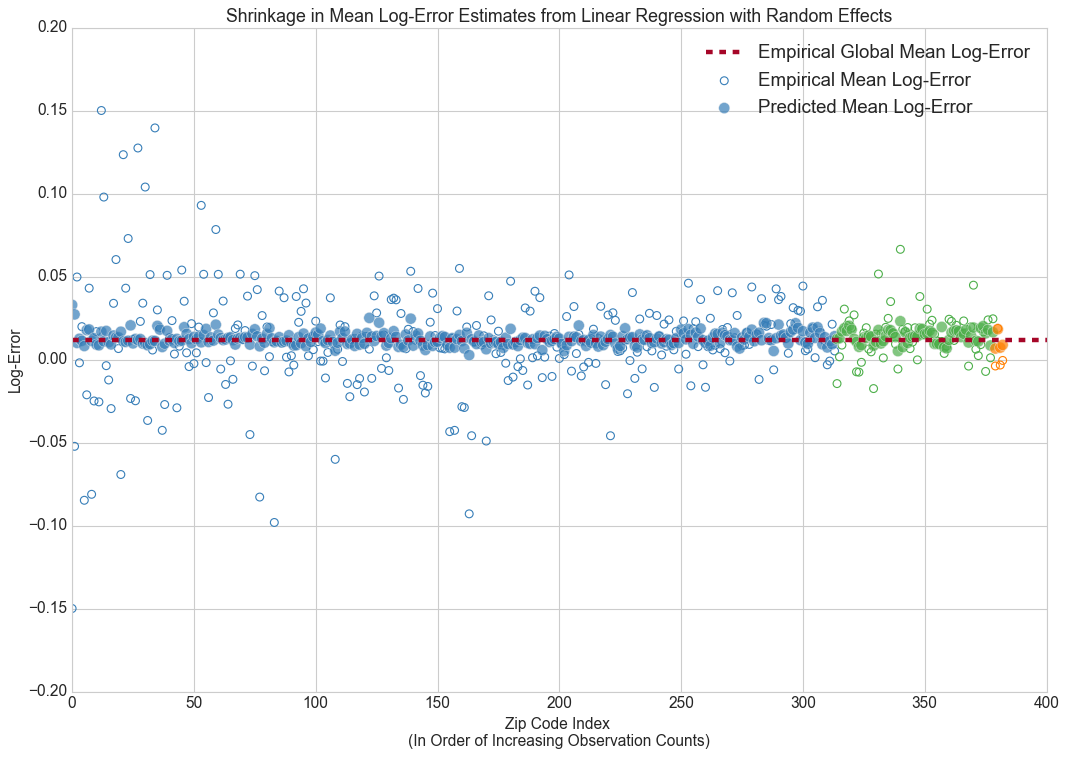

In [183]:
# # retrodict μ_y of training data given inferred posterior parameter distributions
# μ_y_posterior = ed.copy(μ_y, param_posteriors)
# μ_y_posterior_preds = μ_y_posterior.eval( {fixed_effects: X_train, zip_codes_ph: zip_codes[train_index]} )

# # group by zipcode, compute empirical mean `logerror` in training data
# zip_codes_df = pd.DataFrame(
#     data={'logerror': y_train, 'predicted_mean_logerror': μ_y_posterior_preds}, 
#     index=zip_codes[train_index]
# )
# zip_codes_df = zip_codes_df\
#     .groupby(level=0)\
#     .mean()\
#     .clip(-.15, .15)

zip_codes_df = pd.Series(qα_means)
# ! add in global mean + offsets from random effects model
# then do the rest of this cell

# join observation counts of each distinct zipcode
zip_code_obs_counts = pd.Series(zip_codes[train_index].value_counts(), name='obs_count')
zip_codes_df = zip_codes_df.join(zip_code_obs_counts)

# cut counts into three buckets based on size
zip_codes_df['n_obs_color'] = pd.cut(zip_codes_df['obs_count'], bins=3, labels=['#377eb8', '#4daf4a', '#ff7f00'])

zip_codes_df = zip_codes_df\
    .sort_values(by='obs_count')\
    .reset_index(drop=True)
    
# plot shrinkage
plt.figure(figsize=(14, 10))
plt.xlim(0, 400)
average_logerror = zip_codes_df['logerror'].mean()

plt.scatter(zip_codes_df.index, zip_codes_df['logerror'], facecolors='none',
            edgecolors=zip_codes_df['n_obs_color'], s=50, linewidth=1, 
            alpha=1, label='Empirical Mean Log-Error')
plt.scatter(zip_codes_df.index, zip_codes_df['predicted_mean_logerror'], c=zip_codes_df['n_obs_color'], 
            s=100, alpha=.7, label='Predicted Mean Log-Error')
plt.axhline(average_logerror, color='#A60628', linestyle='--', label='Empirical Global Mean Log-Error')
plt.xlabel('Zip Code Index \n(In Order of Increasing Observation Counts)', fontsize=14)
plt.ylabel('Log-Error', fontsize=14)
plt.title('Shrinkage in Mean Log-Error Estimates from Linear Regression with Random Effects', fontsize=16)
plt.legend()

## Neural network with random effects

### Fit model

In [ ]:
def neural_network(fixed_effects, λ=.001, input_dim=D):
    dense = Dense(5, activation='tanh', kernel_regularizer=l2(λ))(fixed_effects)
    output = Dense(1, activation='linear', name='output', kernel_regularizer=l2(λ))(dense)
    return K.squeeze(output, axis=1)

# model
μ_y = α + α_random_effects + neural_network(fixed_effects)
y = Normal(loc=μ_y, scale=tf.ones(N))

In [92]:
latent_vars = {
    β_fixed_effects: qβ_fixed_effects,
    α: qα,
    α_zip_code: qα_zip_code
}

sess.run(INIT_OP)
inference = ed.KLqp(latent_vars, data={fixed_effects: X_train, zip_codes_ph: zip_codes[train_index], y: y_train})
optimizer = tf.train.RMSPropOptimizer(0.01, epsilon=1.0)
inference.initialize(optimizer=optimizer)
inference.run(n_samples=5, n_iter=1000)

1000/1000 [100%] ██████████████████████████████ Elapsed: 18s | Loss: 34491.312


### Criticize model

In [93]:
param_posteriors = {
    β_fixed_effects: qβ_fixed_effects.mean(),
    α: qα.mean(),
    α_zip_code: qα_zip_code.mean()
}
X_val_feed_dict = {
    fixed_effects: X_val,
    zip_codes_ph: zip_codes[val_index]
}
y_posterior = ed.copy(y, param_posteriors)

In [94]:
compute_mean_absolute_error(y_posterior, X_val_feed_dict)

Mean absolute error on validation data: 0.080178


#### Inspect residuals

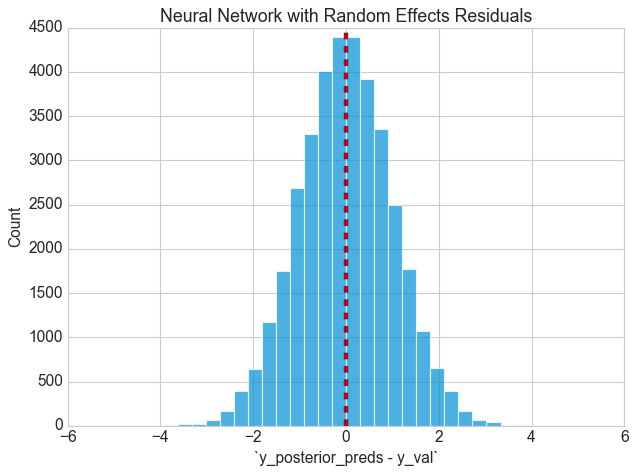

In [184]:
plot_residuals(y_posterior, X_val_feed_dict, title='Neural Network with Random Effects Residuals')

# future work

- varying slopes models
    - we probably need tensorflow for this?
    - covariance matrices
- we could have a random effect on each bias term for each layer
- flexibilities all around
- pymc does missing value imputation it seems

# references
- http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/
- https://blog.keras.io/keras-as-a-simplified-interface-to-tensorflow-tutorial.html
- http://cbonnett.github.io/MDN_EDWARD_KERAS_TF.html